In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

In [1]:


# read all network edgelist from file
def read_edge(net_name):
    path = '/home/hermuba/data0118/network1122/'
    filename = path + net_name + '_lls_edgelist'
    
    # skip first line header!!
    with open(filename, 'rb') as f:
      
        net = nx.read_edgelist(f, nodetype = str, comments = '#')
    return(net)

string = read_edge('string_rm_plasmid')
refseq = read_edge('refseq_rm_plasmid')
eskape = read_edge('eskape_rm_plasmid')
domain = read_edge('domain_rm_plasmid')

In [3]:
# read baysean integrated combined network
with open('/home/hermuba/data0118/network1122/combined_rm_plasmid_baye', 'rb') as f:
    next(f) # skip header
    combined = nx.read_edgelist(f, nodetype = str, comments = '#', delimiter = ',',  data=(('combined_lls',float),))

In [3]:
# read annotation file
gold_anno = pd.read_pickle('/home/hermuba/data0118/goldstandard/ec_rmplasmid_node_anno_df')

In [17]:
# calculate how many nodes, annotation in each network
# network stats comparing them
core_genes = gold_anno.loc[gold_anno['core'] == True]
def net_stat(G):
    # core
    number_of_core = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['core'] == True].index))
    # accessory
    number_of_acc = G.number_of_nodes() - number_of_core
    # hypothetical
    number_of_hypo = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['hypo_nr'] == True].index))
    # mobile
    number_of_mobile = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['is_aclame'] == True].index))
    # CARD genes
    number_of_card = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['is_card'] == True].index))
    # COG annotation
    number_of_cog = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['cog_ID'].notna()].index))
    return([G.number_of_nodes(), 
            G.number_of_edges(), 
            nx.algorithms.components.number_connected_components(G),
           number_of_core,
           number_of_acc,
           number_of_hypo,
           number_of_mobile,
           number_of_card,
           number_of_cog])

# run
df = pd.DataFrame(columns = ['No. nodes', 'No. edges', 'No. components', 'No. core', 'No. accessory', 'No. hypothetical','No. Aclame', 'No. CARD', 'No. COG'], index = ['RefseqNet', 'EskapeNet', 'StringNet','DomainNet', 'pangenomeNet'])
i = 0
for net in [refseq, eskape, string, domain, combined]:
    
    df.iloc[i] = net_stat(net)
    i+=1

# save to file
df.to_csv('/home/hermuba/data0118/fig/netstat.csv')

In [18]:
df

,No. nodes,No. edges,No. components,No. core,No. accessory,No. hypothetical,No. Aclame,No. CARD,No. COG
RefseqNet,20296,1068531,2401,2504,17792,9030,10699,53,7567
EskapeNet,4415,712883,177,1719,2696,389,3125,29,3481
StringNet,3242,263554,1,2359,883,284,1654,22,2671
DomainNet,18601,1795058,676,3342,15259,3208,12371,99,12399
pangenomeNet,26625,3635637,965,3386,23239,10108,15074,101,12560


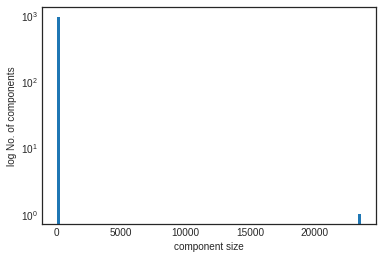

In [20]:
# size v.s. number of components


plt.savefig('/home/hermuba/data0118/fig/combined_component_size.pdf', format = 'pdf', dpi = 300, pad_inches = 1, bbox_inches='tight')

In [32]:
import numpy as np
np.asarray(list(eskape.degree().values()))

array([1609,  621,  276, ...,    2,    2,    1])

most connected node degree  1984
most connected node degree  2352
most connected node degree  995
most connected node degree  3296
most connected node degree  3378


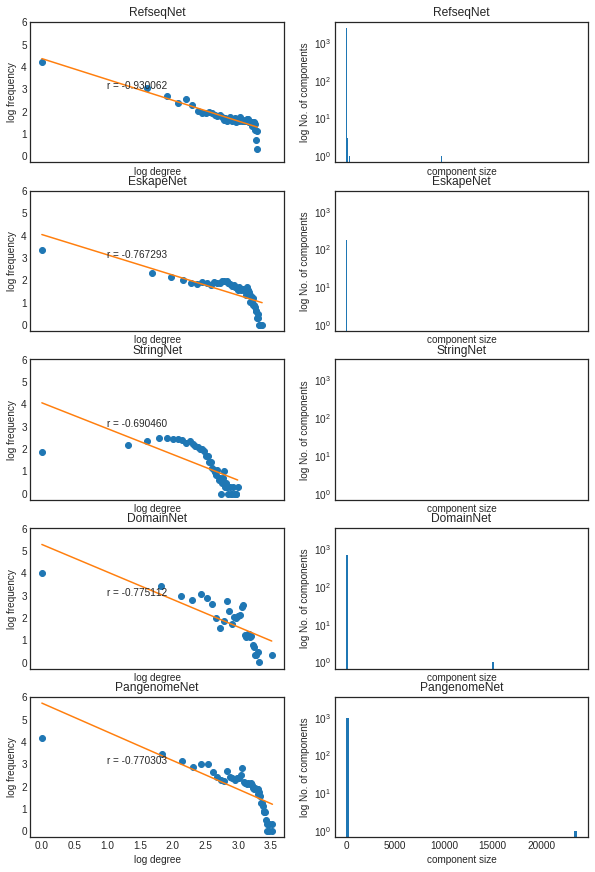

In [10]:
# plot powerlaw and Number of components
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = 'col', sharey = 'col', figsize = (10, 15))

row = 0
names = ['RefseqNet', 'EskapeNet', 'StringNet','DomainNet', 'PangenomeNet']
for net in [refseq, eskape, string, domain, combined]:
    
    # power law
    from network_analysis.net_arch import *
    logx, logy, line, slope, r_value, p_value = power_law(net) # the most connected used to be 1970
    axes[row, 0].plot(logx, logy, 'o', logx, line)
    axes[row,0].text(1, 3,'r = '+ '{:f}'.format(r_value))
    
    axes[row,0].set_title(names[row])
    axes[row, 0].set_xlabel('log degree')
    axes[row, 0].set_ylabel('log frequency')
    
    # subcomponent
    graphs = nx.connected_component_subgraphs(net)
    node_no = [g.number_of_nodes() for g in graphs]

    axes[row,1].hist(node_no, bins = 100, log = True)
    axes[row,1].set_xlabel('component size')
    axes[row,1].set_ylabel('log No. of components')
    axes[row,1].set_title(names[row])
    
    
    # next net
    row += 1

    
    
    
plt.savefig('/home/hermuba/data0118/fig/component_size_powerlaw.pdf', format = 'pdf', dpi = 300, pad_inches = 1, bbox_inches='tight')
    
    


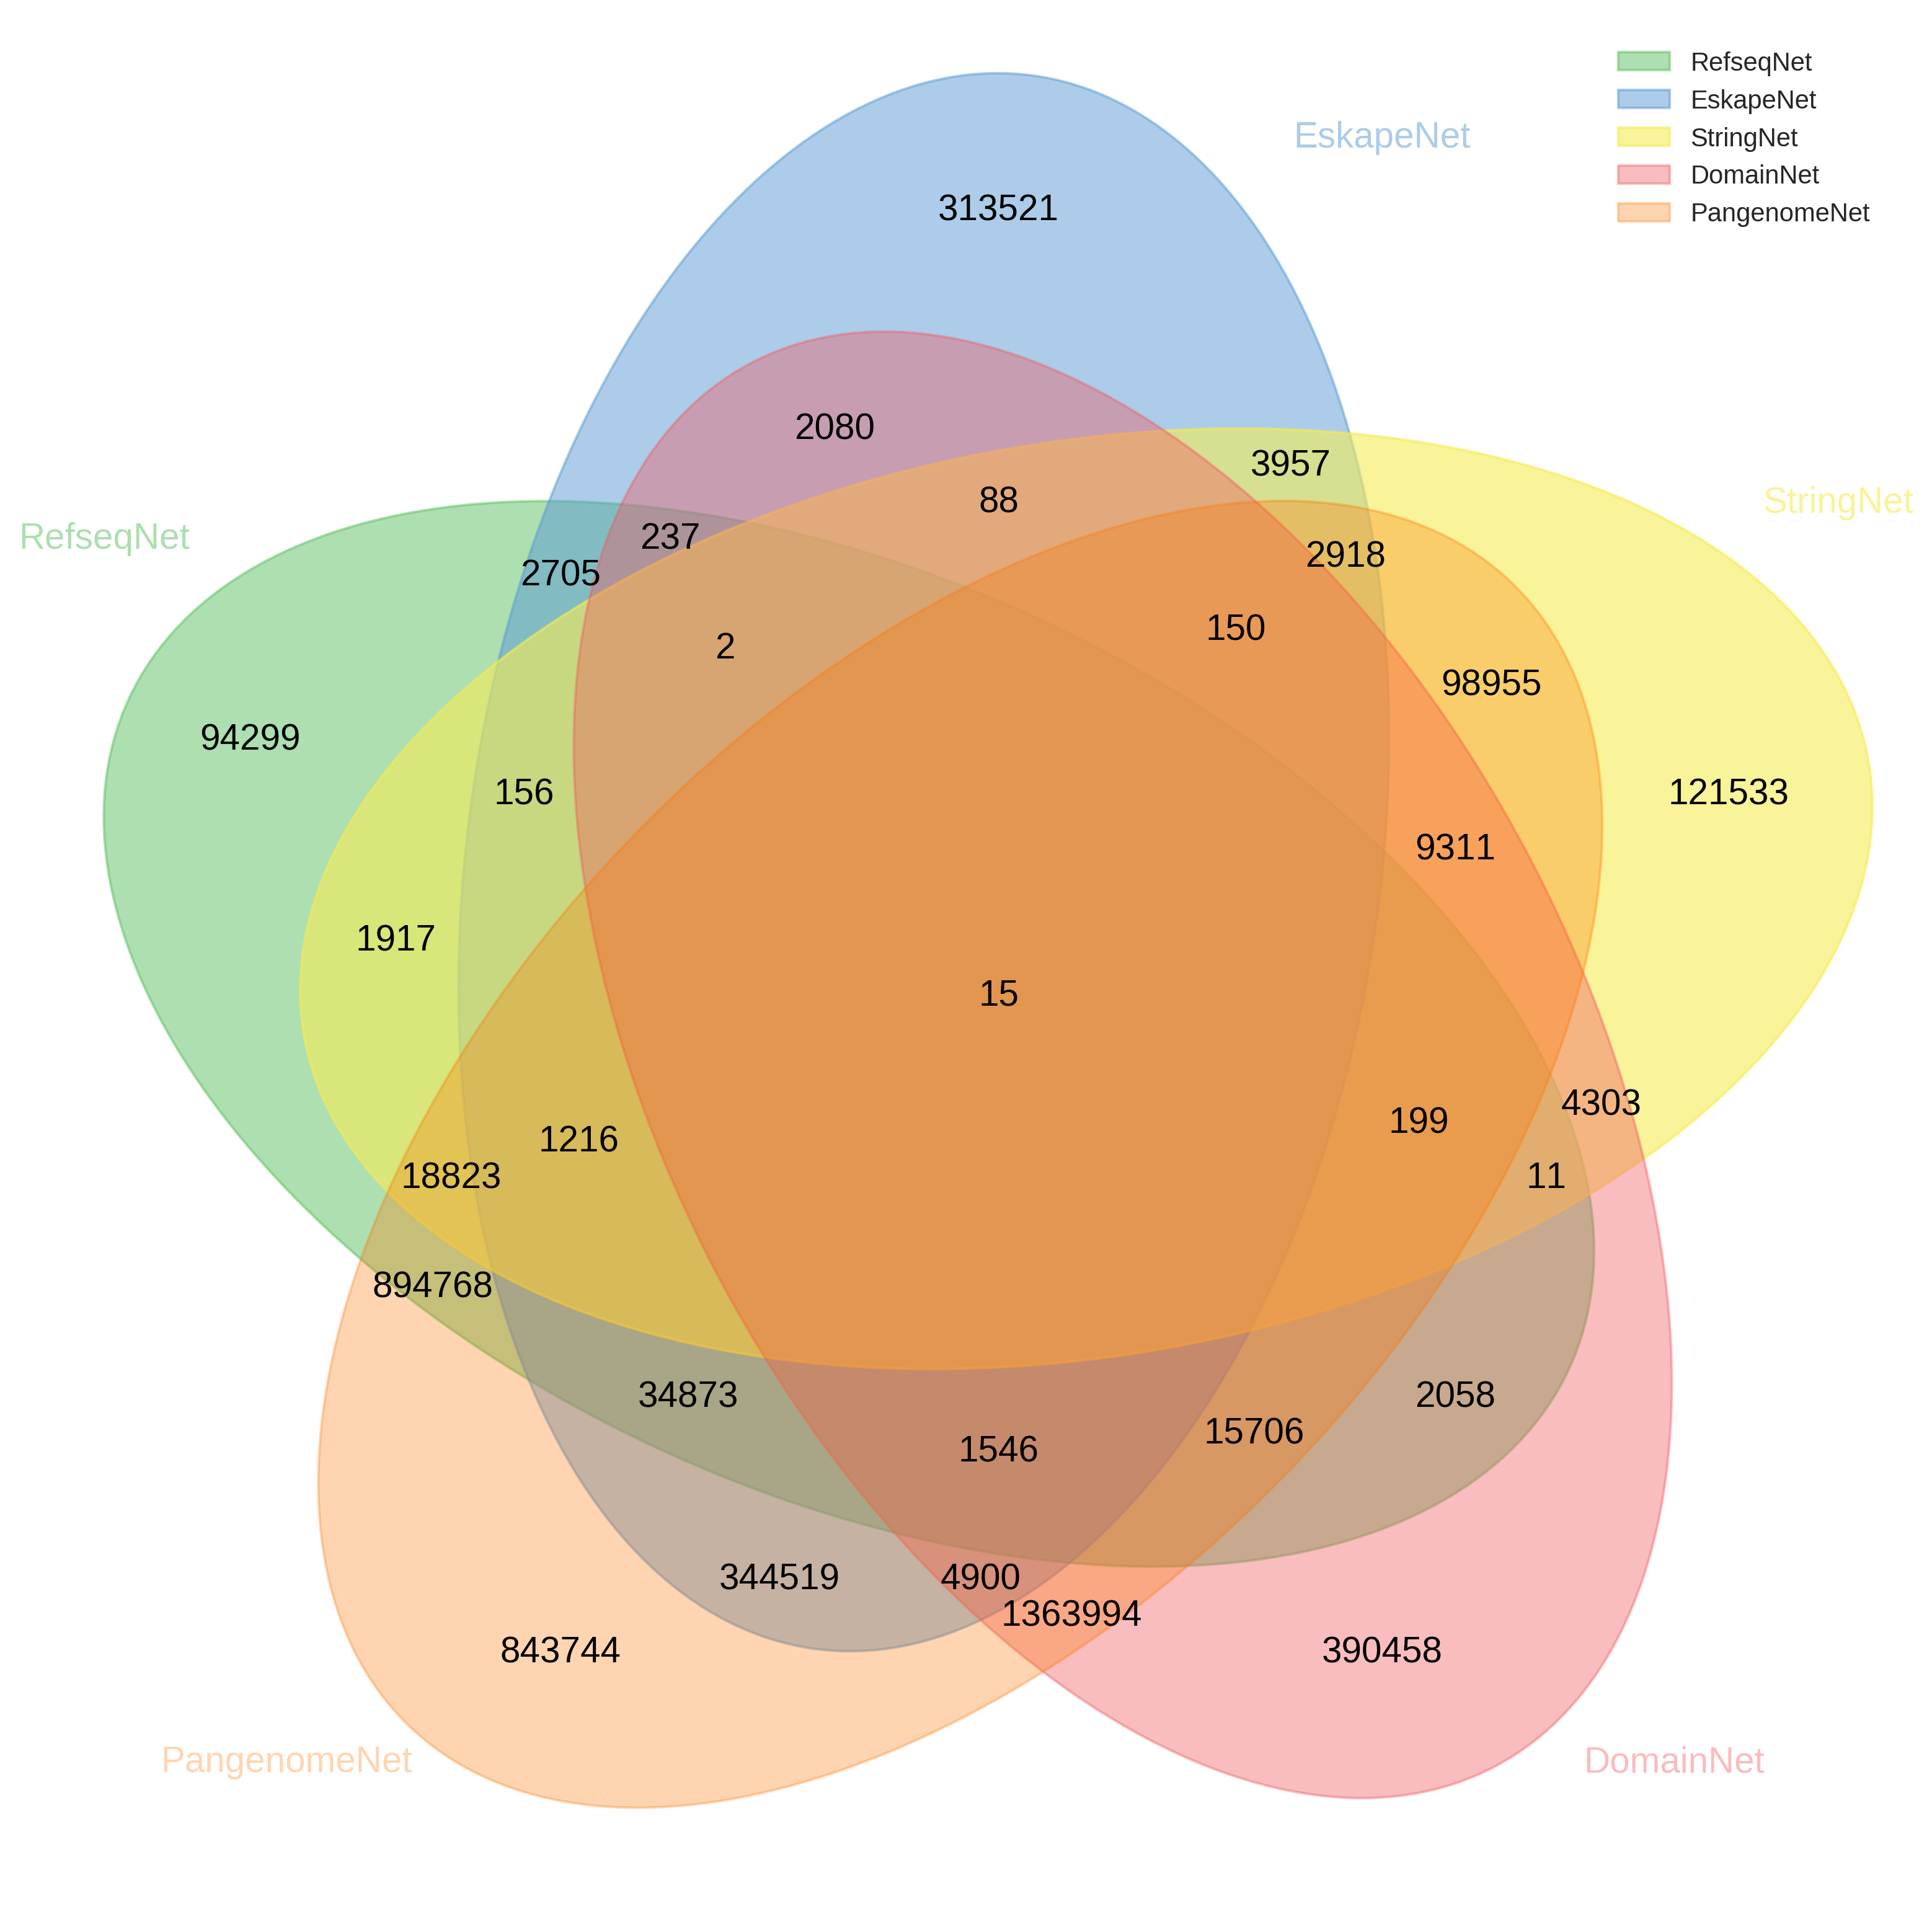

In [16]:
# edge relation
%matplotlib inline
import sys
sys.path.append('/home/hermuba/pyvenn')
import venn

labels = venn.get_labels([refseq.edges(), eskape.edges(), string.edges(), domain.edges(), combined.edges()], fill=['number'])
fig, ax = venn.venn5(labels, names=['RefseqNet', 'EskapeNet', 'StringNet', 'DomainNet', 'PangenomeNet'], dpi = 300)

plt.savefig('/home/hermuba/data0118/fig/edge_venn5.pdf', format = 'pdf', dpi = 300, pad_inches = 1, bbox_inches='tight')
fig.show()



In [17]:
# calculate centrality of each nodes
dc = nx.algorithms.centrality.degree_centrality(combined)
for k in dc.keys():
    gold_anno.loc[k ,'degree_centrality']  = dc[k]

In [20]:
gold_anno.columns

Index(['cog_ID', 'cog_category', 'cluster', 'count', 'core', 'loose_best_ARO',
       'loose_ARO', 'strict_best_ARO', 'strict_ARO', 'is_card', 'resfam',
       'aclame_title', 'is_aclame', 'nr', 'hypo_nr', 'drug_target',
       'is_drug_target', 'GO', 'pathway', 'domain', 'degree_centrality'],
      dtype='object')

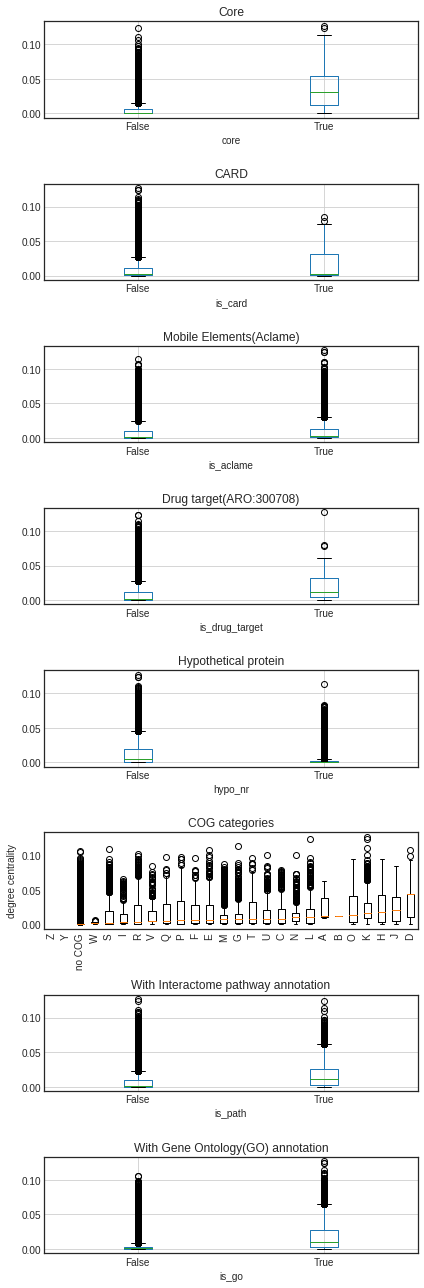

In [108]:
# pangenome property
fig, ax = plt.subplots(nrows = 8, figsize = (6,18), sharey = True)

gold_anno.boxplot(by = 'core', column = 'degree_centrality', ax = ax[0])
plt.sca(ax[0])
plt.title('Core')

gold_anno.boxplot(by = 'is_card', column = 'degree_centrality', ax = ax[1])
plt.sca(ax[1])
plt.title('CARD')

gold_anno.boxplot(by = 'is_aclame', column = 'degree_centrality', ax = ax[2])
plt.sca(ax[2])
plt.title('Mobile Elements(Aclame)')

gold_anno.boxplot(by = 'is_drug_target', column = 'degree_centrality', ax = ax[3])
plt.sca(ax[3])
plt.title('Drug target(ARO:300708)')

gold_anno['hypo_nr'] = gold_anno['hypo_nr'].fillna(False)
gold_anno.boxplot(by = 'hypo_nr', column = 'degree_centrality', ax = ax[4])
plt.sca(ax[4])
plt.title('Hypothetical protein')

# COG category
seq_of_cen = [gold_anno.loc[cog_df.loc[cog_df[cog]].index, 'degree_centrality'].fillna(0) for cog in cog_df.columns]

# sort by median
medians_cog = [cog.median() for cog in seq_of_cen]
med = pd.Series(medians_cog, index = cog_df.columns).fillna(0)
right_order = med.sort_values().index

seq_of_cen = [gold_anno.loc[cog_df.loc[cog_df[cog]].index, 'degree_centrality'].fillna(0) for cog in right_order]

r = ax[5].boxplot(seq_of_cen, labels =right_order)
ax[5].set_ylabel('degree centrality')

plt.sca(ax[5])
n = plt.setp(plt.xticks()[1], rotation=90)
plt.title('COG categories')

# with pathway annotation
gold_anno['is_path'] = gold_anno['pathway'].notnull()

gold_anno.boxplot(by = 'is_path', column = 'degree_centrality', ax = ax[6])
plt.sca(ax[6])
plt.title('With Interactome pathway annotation')

# with GO annotation
gold_anno['is_go'] = gold_anno['GO'].notnull()

gold_anno.boxplot(by = 'is_go', column = 'degree_centrality', ax = ax[7])
plt.sca(ax[7])
plt.title('With Gene Ontology(GO) annotation')

fig.tight_layout()
plt.suptitle("")
plt.savefig('/home/hermuba/data0118/fig/centrality.pdf', format = 'pdf', dpi = 300, pad_inches = 1, bbox_inches='tight')

In [109]:
#gold_anno.to_csv('~/data0118/network1122/ec_rmplasmid_node_anno-2.csv')

In [35]:
# split cog into 0101

split_cog = gold_anno.loc[gold_anno['cog_category'].notnull()]['cog_category'].apply(list)
cog_df = pd.DataFrame(columns = ['J','A','K','L','B','D','Y','V','T','M','N','Z','W','U','O','C','G','E','F','H','I','P','Q','R','S','no COG'], index = gold_anno.index)

# make into 0101 table
for i in split_cog.index:
    cog_lists = split_cog[i]
    for each_category in cog_lists:
        cog_df.loc[i, each_category] = True

# find those without COG
cog_df.loc[gold_anno.loc[gold_anno['cog_category'].isnull()].index, 'no COG'] = True

In [46]:
cog_df.fillna(False, inplace = True)
#cog_df.to_csv('~/data0118/goldstandard/cog_df.csv')

In [9]:
# extract subnetwork for visualization
deg = combined.degree()
d = [node for node in deg.keys() if deg[node] > 30]
sub = combined.subgraph(d)
nx.write_edgelist(sub,'/home/hermuba/data0118/network1122/sub_edge')

In [11]:
nx.write_edgelist(sub,'/home/hermuba/data0118/network1122/sub_edge')